In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound, reboundx
from saturn_system import a_sat, m_sat, R_eq_saturn, J2_sat, J2_inner_satellites, J2_titan, a_saturn, m_sun

In [2]:
iap_inc = np.radians(5.20)
iap_Omega = np.radians(8)
iapetus_ecc = 0.03
solar_inc = np.radians(26.7)
solar_Omega = np.radians(0)

## Test presence of Sun

In [72]:
times_test = np.arange(0, 1e4, 10)
N_test = len(times_test)
sim1 = rebound.Simulation()
sim1.units = ('msaturn', 'km', 'yr')
sim1.add(m=1)
sim1.add(m=m_sat['iapetus'], a=a_sat['iapetus'], e=iapetus_ecc, inc=iap_inc, Omega=iap_Omega, pomega=0, l=0, primary=sim1.particles[0])
sim1.add(m=m_sun, a=a_saturn, inc=solar_inc, Omega=solar_Omega, l=0)
ps1 = sim1.particles
rebx1 = reboundx.Extras(sim1)
gh1 = rebx1.load_force("gravitational_harmonics")
rebx1.add_force(gh1)
ps1[0].params['J2'] = J2_sat + J2_inner_satellites + J2_titan
ps1[0].params['R_eq'] = R_eq_saturn
# sim1.move_to_com()
sim1.integrator = 'whfast'
sim1.dt = sim1.particles[1].P/20
iap_orbit1 = np.zeros((N_test,6))
for i, time in enumerate(times_test):
    sim1.integrate(time)
    p = ps1[1]
    orbit = p.calculate_orbit(primary=sim1.particles[0])
    iap_orbit1[i] = orbit.a, orbit.e, orbit.inc, orbit.pomega, orbit.Omega, orbit.l

In [73]:
sim2 = rebound.Simulation()
sim2.units = ('msaturn', 'km', 'yr')
sim2.add(m=1)
sim2.add(m=m_sat['iapetus'], a=a_sat['iapetus'], e=iapetus_ecc, inc=iap_inc, Omega=iap_Omega, pomega=0, l=0, primary=sim2.particles[0])
ps2 = sim2.particles
rebx2 = reboundx.Extras(sim2)
solar = rebx2.load_force("solar_force")
rebx2.add_force(solar)
gh2 = rebx2.load_force("gravitational_harmonics")
rebx2.add_force(gh2)
ps2[0].params['J2'] = J2_sat + J2_inner_satellites + J2_titan
ps2[0].params['R_eq'] = R_eq_saturn
solar.params['sf_inc'] = solar_inc
solar.params['sf_Omega'] = solar_Omega
solar.params['sf_a'] = a_saturn
solar.params['sf_m'] = m_sun
solar.params['sf_P'] = (4*np.pi**2*a_saturn**3/(sim2.G*m_sun))**0.5
sim2.move_to_com()
sim2.integrator = 'whfast'
sim2.dt = ps2[1].P/20
iap_orbit2 = np.zeros((N_test,6))
for i, time in enumerate(times_test):
    sim2.integrate(time)
    iap_orbit2[i] = ps2[1].a, ps2[1].e, ps2[1].inc, ps2[1].pomega, ps2[1].Omega, ps2[1].l

In [74]:
r_L = ((J2_sat + J2_inner_satellites + J2_titan)*R_eq_saturn**2*a_saturn**3/m_sun)**(1/5)
inc_L = np.arctan(np.sin(2*solar_inc)/(np.cos(2*solar_inc) + 2*r_L**5/a_sat['iapetus']**5))/2
print('inc_L =', np.degrees(inc_L))
inc_to_laplace1 = np.arccos(np.cos(inc_L)*np.cos(iap_orbit1[:,2]) + np.sin(inc_L)*np.sin(iap_orbit1[:,2])*np.cos(iap_orbit1[:,4] - solar_Omega))
inc_to_laplace2 = np.arccos(np.cos(inc_L)*np.cos(iap_orbit2[:,2]) + np.sin(inc_L)*np.sin(iap_orbit2[:,2])*np.cos(iap_orbit2[:,4] - solar_Omega))

inc_L = 15.946035966728196


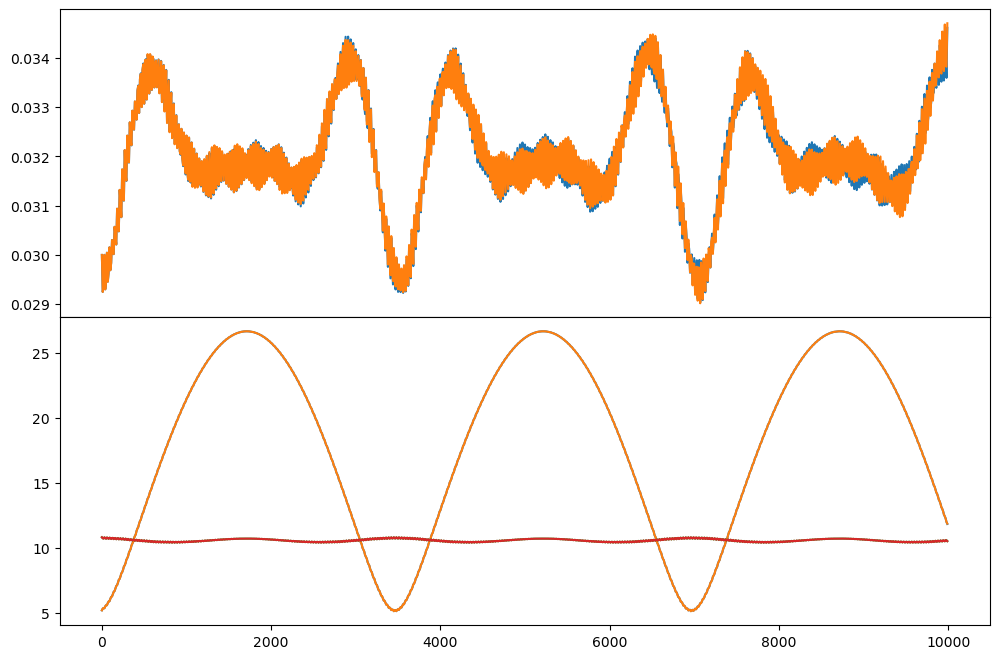

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(12,8), sharex=True, gridspec_kw={'hspace':0})
# axs[0].plot(times, iap_orbit[:,0])
# axs[0].plot(times, sun_orbit[:,0])
# for integrator, (times, iap_orbit, sun_orbit) in sim_results.items():
axs[0].plot(times_test, iap_orbit1[:,1])
axs[0].plot(times_test, iap_orbit2[:,1])
# axs[0].plot(times, sun_orbit1[:,1])
axs[1].plot(times_test, np.degrees(iap_orbit1[:,2]))
# axs[1].plot(times, np.degrees(sun_orbit1[:,2]))
# axs[0].plot(times, sun_orbit2[:,1])
axs[1].plot(times_test, np.degrees(iap_orbit2[:,2]))
axs[1].plot(times_test, np.degrees(inc_to_laplace1))
axs[1].plot(times_test, np.degrees(inc_to_laplace2))
# axs[1].plot(times, np.degrees(sun_orbit2[:,2]))


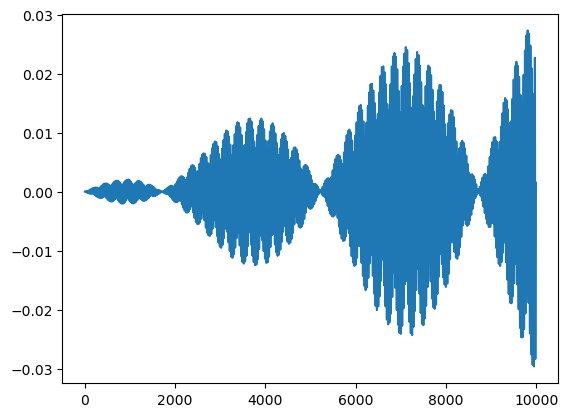

In [76]:
plt.plot(times_test, np.degrees(inc_to_laplace2 - inc_to_laplace1))

## Evection resonance

In [77]:
times = np.arange(0, 3e5, 100)
N = len(times)
sim = rebound.Simulation()
sim.units = ('msaturn', 'km', 'yr')
sim.add(m=1)
sim.add(m=m_sat['iapetus'], a=8*R_eq_saturn, e=0.01, inc=0.01, Omega=0, pomega=0, l=0)
ps = sim.particles
rebx = reboundx.Extras(sim)
solar = rebx.load_force("solar_force")
rebx.add_force(solar)
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)
mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)
ps[0].params['J2'] = J2_sat
ps[0].params['R_eq'] = R_eq_saturn
ps[1].params['tau_a'] = times[-1]*30
ps[1].params['tau_e'] = -times[-1]*30
solar.params['sf_inc'] = np.radians(26.7)
solar.params['sf_Omega'] = 0
solar.params['sf_a'] = a_saturn
solar.params['sf_m'] = m_sun

solar.params['sf_P'] = (4*np.pi**2*a_saturn**3/(sim.G*m_sun))**0.5
sim.move_to_com()
sim.integrator = 'whfast'
sim.dt = ps[1].P/20
moon_orbit = np.zeros((N,6))
for i, time in enumerate(times):
    sim.integrate(time)
    moon_orbit[i] = ps[1].a, ps[1].e, ps[1].inc, ps[1].pomega, ps[1].Omega, ps[1].l

KeyboardInterrupt: 

Text(0, 0.5, '$2\\lambda_{sun} - 2\\varpi$ [$^{\\circ}$]')

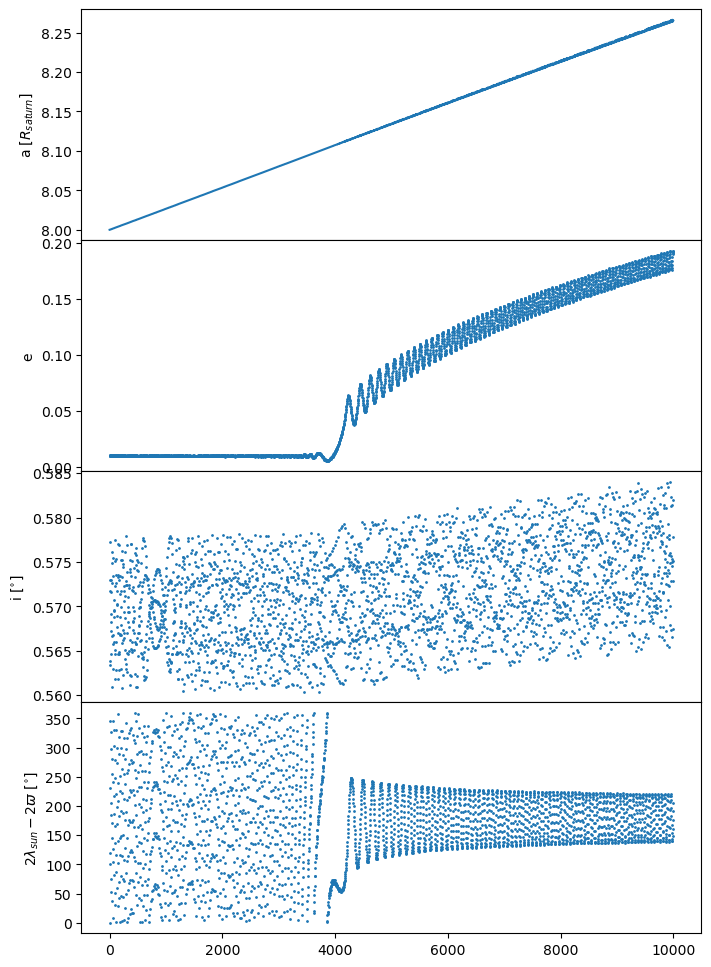

In [27]:
lambda_Sun = np.remainder(2*np.pi*times/solar.params['sf_P'], 2*np.pi)
fig, axs = plt.subplots(4, 1, figsize=(8,12), sharex=True, gridspec_kw={'hspace':0})
axs[0].plot(times/30, moon_orbit[:,0]/R_eq_saturn)
axs[1].scatter(times/30, moon_orbit[:,1], s=1, alpha=1)
axs[2].scatter(times/30, np.degrees(moon_orbit[:,2]), s=1, alpha=1)
axs[3].scatter(times/30, np.degrees(np.remainder(2*moon_orbit[:,3] - 2*lambda_Sun, 2*np.pi)), s=1, alpha=1)
# axs[0].set_xlim(0, 100)
axs[0].set_ylabel('a [$R_{saturn}$]')
axs[1].set_ylabel('e')
axs[2].set_ylabel('i [$^{\circ}$]')
axs[3].set_ylabel(r'$2\lambda_{sun} - 2\varpi$ [$^{\circ}$]')

## Precession test

In [34]:
times = np.arange(0, 3e4, 100)
N = len(times)
sim = rebound.Simulation()
sim.units = ('msaturn', 'km', 'yr')
sim.add(m=1)
sim.add(m=m_sat['titan'], a=15*R_eq_saturn, e=0.03, inc=np.radians(0.3), Omega=0, pomega=0, l=0)
sim.add(m=m_sat['iapetus'], a=60*R_eq_saturn, e=0.03, inc=np.radians(15), Omega=np.radians(50), pomega=np.radians(90), l=0)
ps = sim.particles
rebx = reboundx.Extras(sim)
# solar = rebx.load_force("solar_force")
# rebx.add_force(solar)
# gh = rebx.load_force("gravitational_harmonics")
# rebx.add_force(gh)
# mof = rebx.load_force("modify_orbits_forces")
# rebx.add_force(mof)
# ps[0].params['J2'] = J2_sat
# ps[0].params['R_eq'] = R_eq_saturn
# solar.params['sf_inc'] = np.radians(26.7)
# solar.params['sf_Omega'] = 0
# solar.params['sf_a'] = a_saturn
# solar.params['sf_m'] = m_sun

# solar.params['sf_P'] = (4*np.pi**2*a_saturn**3/(sim.G*m_sun))**0.5
sim.move_to_com()
sim.integrator = 'whfast'
sim.dt = ps[1].P/20
moon_orbit = np.zeros((N,6))
for i, time in enumerate(times):
    sim.integrate(time)
    p = ps[2]
    moon_orbit[i] = p.a, p.e, p.inc, p.pomega, p.Omega, p.l

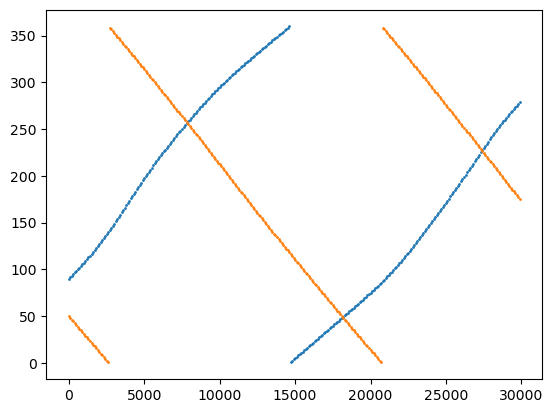

In [35]:
plt.scatter(times, np.degrees(np.remainder(moon_orbit[:,3], 2*np.pi)), s=1)
plt.scatter(times, np.degrees(np.remainder(moon_orbit[:,4], 2*np.pi)), s=1)